In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import modules
import os 
import scipy.io
from scipy import stats
from __future__ import print_function
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd

C:\Users\juke\Miniconda3\envs\tfpls\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load Data from .mat files

In [2]:
test=scipy.io.loadmat('idp_connectome_aparc_length.mat')
aparcl=np.array(test['connectome_aparc_length'])
print(aparcl.shape)

test=scipy.io.loadmat('idp_connectome_aparc_count.mat')
aparcc=np.array(test['connectome_aparc_count'])
print(aparcc.shape)

test=scipy.io.loadmat('idp_connectome_aparc2009_length.mat')
aparc2l=np.array(test['connectome_aparc2009_length'])
print(aparc2l.shape)

test=scipy.io.loadmat('idp_connectome_aparc2009_count.mat')
aparc2c=np.array(test['connectome_aparc2009_count'])
print(aparc2c.shape)


(84, 84, 211)
(84, 84, 211)
(164, 164, 211)
(164, 164, 211)


## Zeropad smaller data, reorganize shape

In [3]:
zeromatal=np.zeros([164,164,211])
zeromatac=np.zeros([164,164,211])

zeromatal[40:124,40:124,:]=aparcl
zeromatac[40:124,40:124,:]=aparcc

aparcl=zeromatal
aparcc=zeromatac

X=np.zeros([164,164,211,4])
X[:,:,:,0]=aparcl
X[:,:,:,1]=aparcc
X[:,:,:,2]=aparc2l
X[:,:,:,3]=aparc2c

X=X.transpose([2,0,1,3])
print(X.shape)

(211, 164, 164, 4)


In [4]:
datasubjid=pd.read_csv('idp_data_1_mor.csv',header=0)
datasubjid=np.array(datasubjid)
datasubjid=datasubjid[:,0]
print(datasubjid.shape)
matsubjid=pd.read_csv('idp_connectome_subjectlist.csv',header=0)
matsubjid=np.array(matsubjid)
print(matsubjid.shape)

filtindex=np.isin(matsubjid,datasubjid)
filtindex=filtindex.ravel()

X=X[filtindex,:,:,:]
print(X.shape)








(208,)
(211, 1)
(208, 164, 164, 4)


## load labels, index data for all 6 types

In [41]:
data=pd.read_csv('idp_data_1_mor.csv',header=0)
data=np.array(data)

ad_smi=data[:,5]
mci_smi=data[:,6]
ad_mci=data[:,7]

adonly_smi=data[:,8]
adonly_mci=data[:,9]
adonly_adwithsmallvv=data[:,10]

print(ad_smi.shape)

ind_num=np.isnan(ad_smi)
y_adsmi=ad_smi[~ind_num]
X_adsmi=X[~ind_num,:,:,:]

ind_num=np.isnan(mci_smi)
y_mcismi=mci_smi[~ind_num]
X_mcismi=X[~ind_num,:,:,:]

ind_num=np.isnan(ad_mci)
y_admci=ad_mci[~ind_num]
X_admci=X[~ind_num,:,:,:]


# not really used
ind_num=np.isnan(adonly_smi)
y_adonlysmi=adonly_smi[~ind_num]
X_adonlysmi=X[~ind_num,:,:,:]

ind_num=np.isnan(adonly_mci)
y_adonlymci=adonly_mci[~ind_num]
X_adonlymci=X[~ind_num,:,:,:]

ind_num=np.isnan(adonly_adwithsmallvv)
y_adonlyadwithsmallvv=adonly_adwithsmallvv[~ind_num]
X_adonlyadwithsmallvv=X[~ind_num,:,:,:]


(208,)


In [7]:
X_variables=np.zeros([208,5000])

In [19]:
# Augment data to increase dataset size
from scipy.ndimage.interpolation import rotate

X_rot=X
angle=2.0
for i in range(X_rot.shape[0]):
    for j in range(X_rot.shape[3]):
        X_rot[i,:,:,j]=rotate(X_rot[i,:,:,j],angle,reshape=False)
print(X_rot.shape)

X_flip=X
for i in range(X_rot.shape[0]):
    for j in range(X_rot.shape[3]):
        X_flip[i,:,:,j]=np.flip(X_flip[i,:,:,j],axis=0)
print(X_flip.shape)

X_shift=X
shift_height=2
shift_width=2
X_shift=np.roll(X_shift,shift_height,axis=1)
X_shift=np.roll(X_shift,shift_width,axis=2)
print(X_shift.shape)

X_noise=X
mean = 0
var = 0.1
sigma = var**0.5
amplitude=1
noise2add=np.random.normal(mean,sigma,X_noise.shape)
X_noise=X_noise+noise2add*amplitude
print(X_noise.shape)



(208, 164, 164, 4)
(208, 164, 164, 4)
(208, 164, 164, 4)
(208, 164, 164, 4)


In [29]:
tester=np.tile(ind_num,5)
print(tester.shape)

X_total=np.concatenate((X,X_rot,X_flip,X_shift,X_noise),axis=0)
print(X_total.shape)
X_var_total=np.concatenate((X_variables,X_variables,X_variables,X_variables,X_variables),axis=0)
print(X_var_total.shape)



(1040,)
(1040, 164, 164, 4)
(1040, 5000)


In [31]:
data=pd.read_csv('idp_data_1_mor.csv',header=0)
data=np.array(data)

ad_smi=data[:,5]
mci_smi=data[:,6]
ad_mci=data[:,7]

print(ad_smi.shape)

ind_num=np.isnan(ad_smi)
ind_num=np.tile(ind_num,5)
y_adsmi=np.tile(ad_smi,5)
y_adsmi=y_adsmi[~ind_num]
X_adsmi=X_total[~ind_num,:,:,:]
print(X_adsmi.shape)
print(y_adsmi.shape)

ind_num=np.isnan(mci_smi)
y_mcismi=mci_smi[~ind_num]
X_mcismi=X[~ind_num,:,:,:]

ind_num=np.isnan(ad_mci)
y_admci=ad_mci[~ind_num]
X_admci=X[~ind_num,:,:,:]

(208,)
(730, 164, 164, 4)
(730,)


## Run CNN with 5fold Cross validation for AD_SMI

In [49]:
from sklearn.model_selection import RepeatedStratifiedKFold
from CNN_codes.CNN_with_addvariables import cnn_training

rskf=RepeatedStratifiedKFold(n_splits=5,n_repeats=5)
store_acc=[]
for train_index,test_index in rskf.split(X_adsmi,y_adsmi):
    print("TRAIN:",train_index.shape,"TEST:",test_index.shape)
    # should augment data post split, think of incorporating the data augmention here
    X_train,X_test=X_adsmi[train_index],X_adsmi[test_index]
    y_train,y_test=y_adsmi[train_index],y_adsmi[test_index]
    X_trainvar,X_valvar=X_var_total[train_index],X_var_total[test_index]
    
    
    X_rot=X_train
    angle=2.0
    for i in range(X_rot.shape[0]):
        for j in range(X_rot.shape[3]):
            X_rot[i,:,:,j]=rotate(X_rot[i,:,:,j],angle,reshape=False)
    print(X_rot.shape)

    X_flip=X_train
    for i in range(X_rot.shape[0]):
        for j in range(X_rot.shape[3]):
            X_flip[i,:,:,j]=np.flip(X_flip[i,:,:,j],axis=0)
    print(X_flip.shape)

    X_shift=X_train
    shift_height=2
    shift_width=2
    X_shift=np.roll(X_shift,shift_height,axis=1)
    X_shift=np.roll(X_shift,shift_width,axis=2)
    print(X_shift.shape)

    X_noise=X_train
    mean = 0
    var = 0.1
    sigma = var**0.5
    amplitude=1
    noise2add=np.random.normal(mean,sigma,X_noise.shape)
    X_noise=X_noise+noise2add*amplitude
    print(X_noise.shape)
    
    X_train_total=np.concatenate((X_train,X_rot,X_flip,X_shift,X_noise),axis=0)
    y_train_total=np.tile(y_train,5)
    X_trainvar_total=np.concatenate((X_trainvar,X_trainvar,X_trainvar,X_trainvar,X_trainvar),axis=0)
    
    mask=np.random.choice(X_train_total.shape[0],X_train_total.shape[0],replace=False)
    print(mask.shape)
    X_train_total=X_train_total[mask,:,:,:]
    y_train_total=y_train_total[mask,]
    X_trainvar_total=X_trainvar_total[mask,:]
    
    tf.reset_default_graph()
    record_acc,recordtrainacc,recordvalacc=cnn_training(X_train,y_train,X_trainvar,X_test,y_test,X_valvar,fc_units=[500,200,2], 
                 conv_featmap=[6,10,20],l2_norm=0.01,seed=235,
                 learning_rate=1e-3,epoch=20,batch_size=10,imglen=164)
    store_acc.append(record_acc)

mean_acc=np.mean(np.array(store_acc))
mean_std=np.std(store_acc)

print('AD_SMI average accuracy is: ',mean_acc)
print('AD_SMI average standard deviation is: ',mean_std)
    
    

TRAIN: (116,) TEST: (30,)
(116, 164, 164, 4)
(116, 164, 164, 4)
(116, 164, 164, 4)
(116, 164, 164, 4)
(580,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 11
epoch 1 
Best validation accuracy! iteration:11 accuracy: 80.0%
epoch 2 
epoch 3 


KeyboardInterrupt: 

In [37]:
print(train_index.shape)

(365,)


In [64]:
print(store_acc)

[86.66666666666667, 96.55172413793103, 93.10344827586206, 96.55172413793103, 89.65517241379311, 93.33333333333333, 93.10344827586206, 89.65517241379311, 100.0, 82.75862068965517, 93.33333333333333, 96.55172413793103, 100.0, 68.9655172413793, 89.65517241379311, 100.0, 86.20689655172414, 96.55172413793103, 100.0, 96.55172413793103, 93.33333333333333, 96.55172413793103, 100.0, 96.55172413793103, 96.55172413793103]


## Runn CNN with 5fold CV for MCI_SMI

In [66]:
from sklearn.model_selection import RepeatedStratifiedKFold
from CNN_codes.CNN_test import cnn_training

rskf=RepeatedStratifiedKFold(n_splits=5,n_repeats=2)
store_acc=[]
for train_index,test_index in rskf.split(X_mcismi,y_mcismi):
    print("TRAIN:",train_index,"TEST:",test_index)
    print("Number of training points: ",train_index.shape)
    print('Number of testing points: ',test_index.shape)
    X_train,X_test=X_mcismi[train_index],X_mcismi[test_index]
    y_train,y_test=y_mcismi[train_index],y_mcismi[test_index]
    tf.reset_default_graph()
    record_acc=cnn_training(X_train,y_train,X_test,y_test,fc_units=[500,200,2], 
                 conv_featmap=[6,10,20],l2_norm=0.01,seed=235,
                 learning_rate=1e-3,epoch=20,batch_size=2,imglen=164)
    store_acc.append(record_acc)

mean_acc=np.mean(np.array(store_acc))
print('MCI_SMI average accuracy is: ',mean_acc)
print(store_acc)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 25
 27 28 29 30 31 32 34 37 38 39 43 44 45 46 48 49 51 52 53 54 55 56 57 58
 59 61 62 63 64 67 68 69 70 72 73 74 76 78 79 81 82 83 84 86 87 88 89 90
 91 92 93 94 96] TEST: [17 24 26 33 35 36 40 41 42 47 50 60 65 66 71 75 77 80 85 95 97]
Number of training points:  (77,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
(?, 33620)
number of batches for training: 38
epoch 1 
Best validation accuracy! iteration:38 accuracy: 52.38095238095238%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:190 accuracy: 61.904761904761905%
epoch 6 
epoch 7 
epoch 8 
epoch 9 
Best validation accuracy! iteration:342 accuracy: 66.66666666666666%
epoch 10 
epoch 11 
epoch 12 
Best validation accuracy! iteration:456 accuracy: 71.42857142857143%
epoch 13 
Best validation accuracy! iteration:494 accuracy: 76.19047619047619%
epoch 14 
Be

(?, 33620)
number of batches for training: 39
epoch 1 
Best validation accuracy! iteration:39 accuracy: 52.63157894736842%
epoch 2 
Best validation accuracy! iteration:78 accuracy: 57.89473684210526%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
Best validation accuracy! iteration:273 accuracy: 73.6842105263158%
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 73.6842105263158. Model named cnn_1518188352.
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 16 19 20 21 22 23 25 27 28 30
 31 32 33 34 35 36 37 39 42 45 46 47 48 49 50 52 53 55 56 58 59 60 62 64
 65 66 68 69 70 71 72 73 74 75 76 77 78 79 80 82 83 84 85 86 87 88 89 90
 91 92 93 94 95 96 97] TEST: [ 6 15 17 18 24 26 29 38 40 41 43 44 51 54 57 61 63 67 81]
Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.

## Run CNN with 5fold CV for AD_MCI

In [67]:
from sklearn.model_selection import RepeatedStratifiedKFold
from CNN_codes.CNN_test import cnn_training

rskf=RepeatedStratifiedKFold(n_splits=5,n_repeats=2)
store_acc=[]
for train_index,test_index in rskf.split(X_admci,y_admci):
    print("Number of training points: ",train_index.shape)
    print('Number of testing points: ',test_index.shape)
    X_train,X_test=X_admci[train_index],X_admci[test_index]
    y_train,y_test=y_admci[train_index],y_admci[test_index]
    tf.reset_default_graph()
    record_acc=cnn_training(X_train,y_train,X_test,y_test,fc_units=[500,200,2], 
                 conv_featmap=[6,10,20],l2_norm=0.01,seed=235,
                 learning_rate=1e-3,epoch=20,batch_size=2,imglen=164)
    store_acc.append(record_acc)

mean_acc=np.mean(np.array(store_acc))
print('AD_MCI average accuracy is: ',mean_acc)
print(store_acc)

Number of training points:  (137,)
Number of testing points:  (35,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 68
epoch 1 
Best validation accuracy! iteration:68 accuracy: 40.0%
epoch 2 
Best validation accuracy! iteration:136 accuracy: 60.0%
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:340 accuracy: 65.71428571428572%
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 65.71428571428572. Model named cnn_1518189170.
Number of training points:  (137,)
Number of testing points:  (35,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 68
epoch 1 
Best validation accuracy! iteration:68 accuracy: 65.71428571428572%
epoch 2 
Best validation accuracy! iteration:136 accuracy: 68.571428

## Run CNN on all data, 5 fold CV for 3-label classification

Number of training points:  (165,)
Number of testing points:  (43,)
Building Network Parameters: 
fc_units=[800, 500, 3]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 16
epoch 1 
Best validation accuracy! iteration:16 accuracy: 53.48837209302326%
epoch 2 
Best validation accuracy! iteration:32 accuracy: 55.81395348837209%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
Best validation accuracy! iteration:96 accuracy: 58.13953488372093%
epoch 7 
epoch 8 
epoch 9 
Best validation accuracy! iteration:144 accuracy: 60.46511627906977%
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 60.46511627906977. Model named cnn_1518210158.


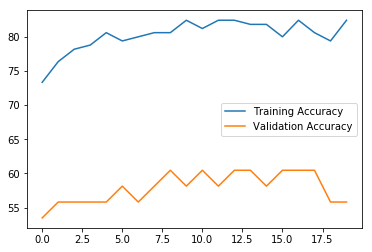

Number of training points:  (166,)
Number of testing points:  (42,)
Building Network Parameters: 
fc_units=[800, 500, 3]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 16
epoch 1 
Best validation accuracy! iteration:16 accuracy: 71.42857142857143%
epoch 2 
Best validation accuracy! iteration:32 accuracy: 73.80952380952381%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 73.80952380952381. Model named cnn_1518210517.


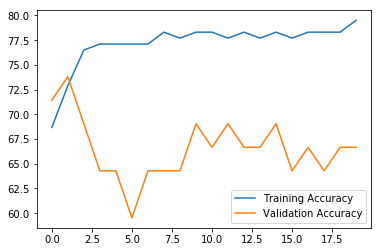

Number of training points:  (167,)
Number of testing points:  (41,)
Building Network Parameters: 
fc_units=[800, 500, 3]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 16
epoch 1 
Best validation accuracy! iteration:16 accuracy: 48.78048780487805%
epoch 2 
Best validation accuracy! iteration:32 accuracy: 56.09756097560975%
epoch 3 
epoch 4 
Best validation accuracy! iteration:64 accuracy: 58.53658536585366%
epoch 5 
epoch 6 
epoch 7 
epoch 8 
Best validation accuracy! iteration:128 accuracy: 60.97560975609756%
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 60.97560975609756. Model named cnn_1518210862.


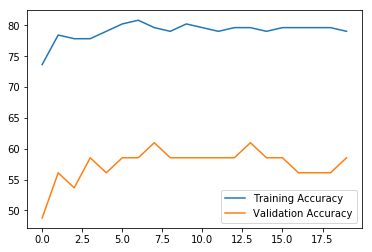

Number of training points:  (167,)
Number of testing points:  (41,)
Building Network Parameters: 
fc_units=[800, 500, 3]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 16
epoch 1 
Best validation accuracy! iteration:16 accuracy: 58.53658536585366%
epoch 2 
Best validation accuracy! iteration:32 accuracy: 60.97560975609756%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
Best validation accuracy! iteration:112 accuracy: 63.41463414634146%
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 63.41463414634146. Model named cnn_1518211214.


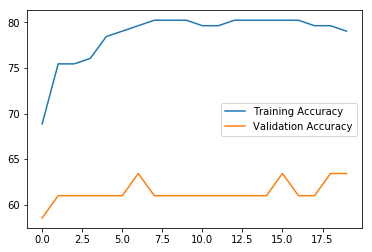

Number of training points:  (167,)
Number of testing points:  (41,)
Building Network Parameters: 
fc_units=[800, 500, 3]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 16
epoch 1 
Best validation accuracy! iteration:16 accuracy: 56.09756097560975%
epoch 2 
Best validation accuracy! iteration:32 accuracy: 58.53658536585366%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
Best validation accuracy! iteration:112 accuracy: 60.97560975609756%
epoch 8 
epoch 9 
epoch 10 
Best validation accuracy! iteration:160 accuracy: 63.41463414634146%
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 63.41463414634146. Model named cnn_1518211548.


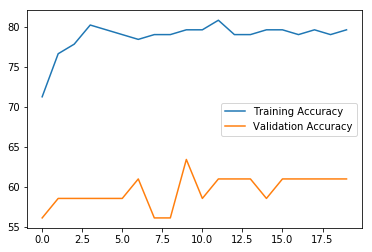

AD_MCI average accuracy is:  64.41590362747482
[60.46511627906977, 73.80952380952381, 60.97560975609756, 63.41463414634146, 63.41463414634146]


In [82]:
y=data[:,1]

from sklearn.model_selection import RepeatedStratifiedKFold
from CNN_codes.CNN_test import cnn_training

rskf=RepeatedStratifiedKFold(n_splits=5,n_repeats=1)
store_acc=[]
for train_index,test_index in rskf.split(X,y):
    print("Number of training points: ",train_index.shape)
    print('Number of testing points: ',test_index.shape)
    X_train,X_test=X[train_index],X[test_index]
    y_train,y_test=y[train_index],y[test_index]
    tf.reset_default_graph()
    record_acc,recordtrainacc,recordvalacc=cnn_training(X_train,y_train,X_test,y_test,fc_units=[800,500,3], 
                 conv_featmap=[6,10,20],l2_norm=0.01,seed=235,
                 learning_rate=1e-3,epoch=20,batch_size=10,imglen=164)
    store_acc.append(record_acc)
    plt.plot(recordtrainacc,label='Training Accuracy')
    plt.plot(recordvalacc,label="Validation Accuracy")
    plt.legend()
    plt.show()

mean_acc=np.mean(np.array(store_acc))
print('AD_MCI average accuracy is: ',mean_acc)
print(store_acc)


## Test hyperparameters here for other nets

Number of training points:  (116,)
Number of testing points:  (30,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 96.66666666666667%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 96.66666666666667. Model named cnn_1518530703.


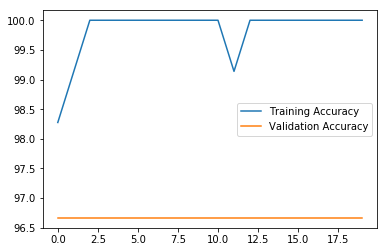

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518530959.


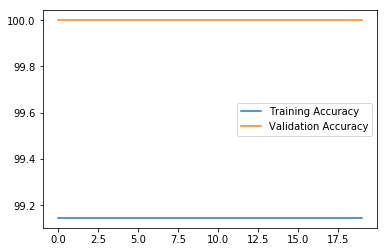

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518531201.


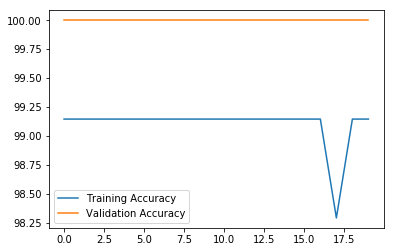

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518531440.


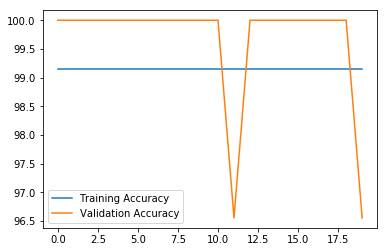

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518531684.


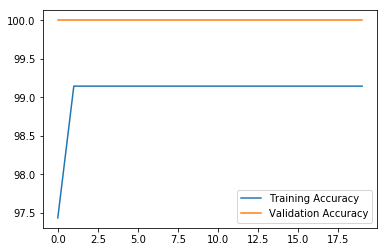

Number of training points:  (116,)
Number of testing points:  (30,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518531928.


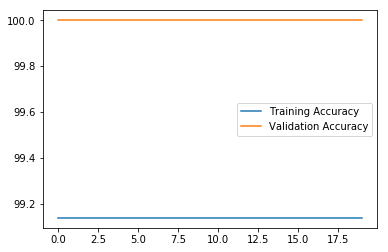

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518532167.


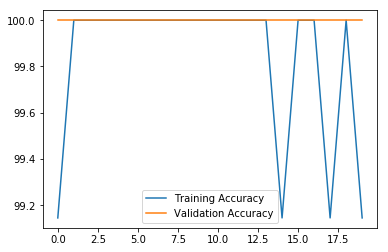

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 96.55172413793103%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 96.55172413793103. Model named cnn_1518532406.


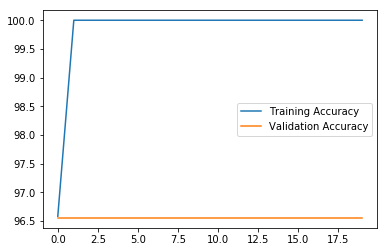

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518532647.


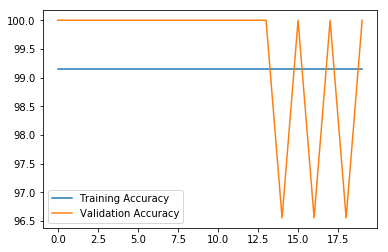

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 96.55172413793103%
epoch 2 
Best validation accuracy! iteration:46 accuracy: 100.0%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518532885.


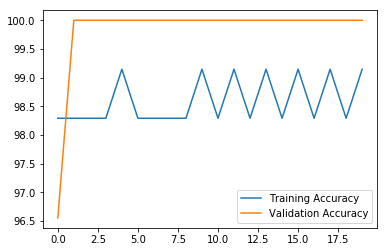

Number of training points:  (116,)
Number of testing points:  (30,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 96.66666666666667%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 96.66666666666667. Model named cnn_1518533131.


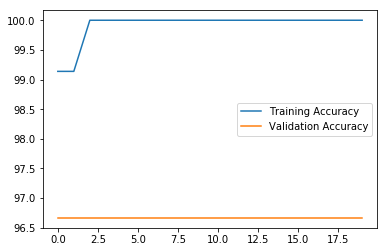

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518533381.


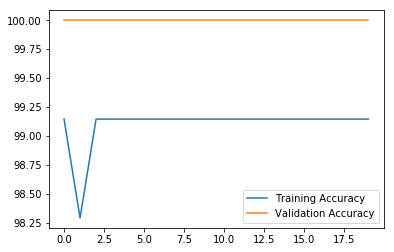

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518533623.


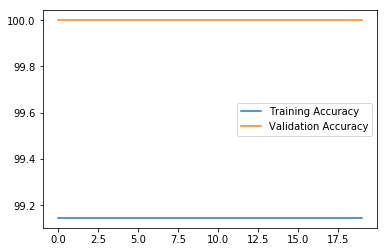

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518533861.


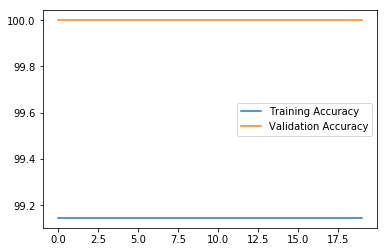

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518534102.


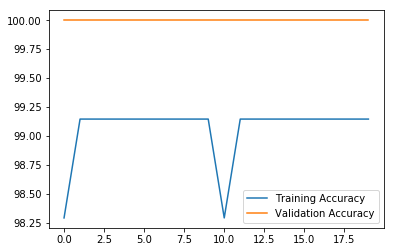

Number of training points:  (116,)
Number of testing points:  (30,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518534346.


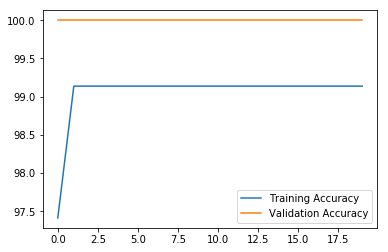

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518534644.


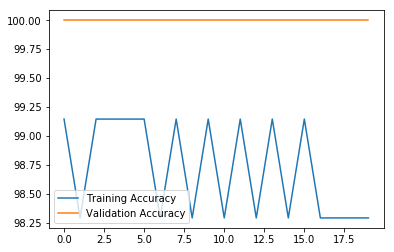

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 96.55172413793103%
epoch 2 
Best validation accuracy! iteration:46 accuracy: 100.0%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518534947.


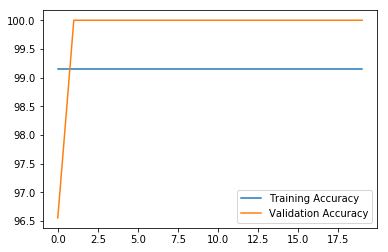

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 96.55172413793103%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 96.55172413793103. Model named cnn_1518535232.


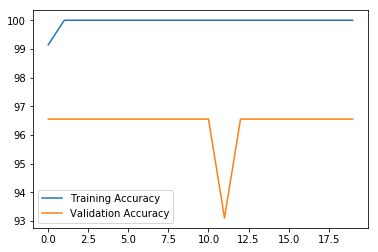

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518535516.


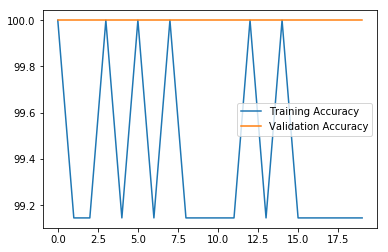

Number of training points:  (116,)
Number of testing points:  (30,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 96.66666666666667%
epoch 2 
Best validation accuracy! iteration:46 accuracy: 100.0%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518535772.


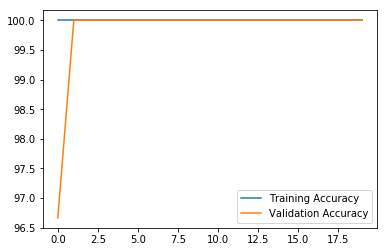

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518536031.


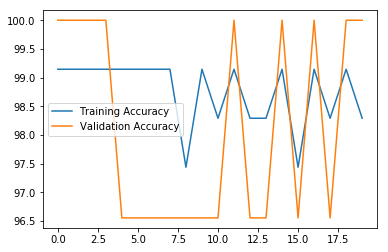

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 100.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518536279.


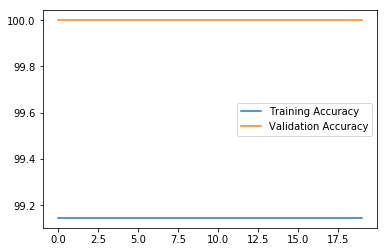

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 96.55172413793103%
epoch 2 
Best validation accuracy! iteration:46 accuracy: 100.0%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 100.0. Model named cnn_1518536532.


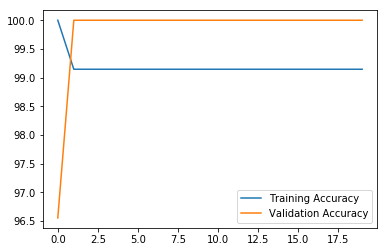

Number of training points:  (117,)
Number of testing points:  (29,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 23
epoch 1 
Best validation accuracy! iteration:23 accuracy: 96.55172413793103%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 96.55172413793103. Model named cnn_1518536795.


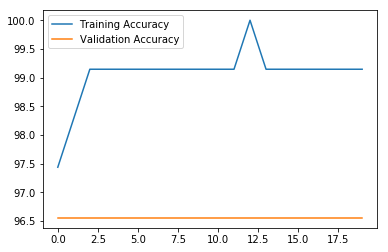

AD_SMI average accuracy is:  99.31954022988506


In [91]:
from sklearn.model_selection import RepeatedStratifiedKFold
from CNN_codes.CNN_test import cnn_training

rskf=RepeatedStratifiedKFold(n_splits=5,n_repeats=5)
store_acc=[]
for train_index,test_index in rskf.split(X_adsmi,y_adsmi):
    print("Number of training points: ",train_index.shape)
    print('Number of testing points: ',test_index.shape)
    X_train,X_test=X_adsmi[train_index],X_adsmi[test_index]
    y_train,y_test=y_adsmi[train_index],y_adsmi[test_index]
    tf.reset_default_graph()
    record_acc,recordtrainacc,recordvalacc=cnn_training(X_train,y_train,X_test,y_test,fc_units=[500,200,2], 
                 conv_featmap=[6,10,20],l2_norm=0.01,seed=235,
                 learning_rate=1e-3,epoch=20,batch_size=5,imglen=164)
    store_acc.append(record_acc)
    plt.plot(recordtrainacc,label='Training Accuracy')
    plt.plot(recordvalacc,label="Validation Accuracy")
    plt.legend()
    plt.show()

mean_acc=np.mean(np.array(store_acc))
print('AD_SMI average accuracy is: ',mean_acc)

Number of training points:  (77,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 76.19047619047619%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 76.19047619047619. Model named cnn_1518542086.


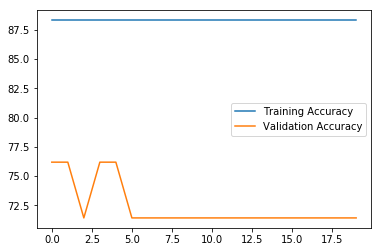

Number of training points:  (78,)
Number of testing points:  (20,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 90.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 90.0. Model named cnn_1518542243.


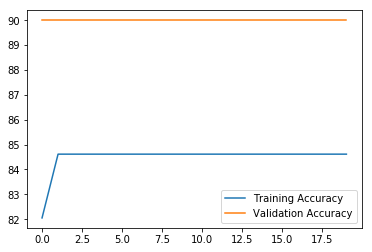

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 89.47368421052632%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 89.47368421052632. Model named cnn_1518542397.


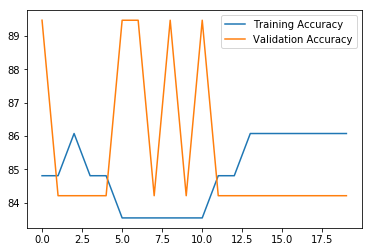

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 84.21052631578948%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 89.47368421052632%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 89.47368421052632. Model named cnn_1518542551.


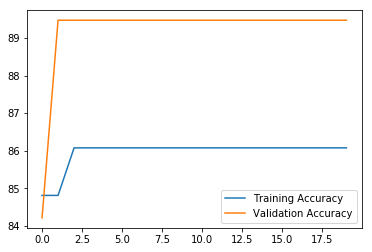

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 89.47368421052632%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 89.47368421052632. Model named cnn_1518542712.


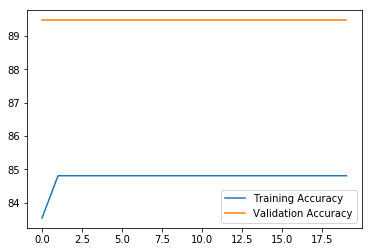

Number of training points:  (77,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 95.23809523809524%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 95.23809523809524. Model named cnn_1518542866.


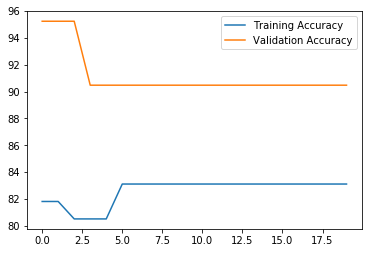

Number of training points:  (78,)
Number of testing points:  (20,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 95.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 95.0. Model named cnn_1518543013.


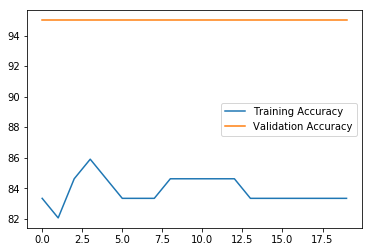

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 78.94736842105263%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 78.94736842105263. Model named cnn_1518543171.


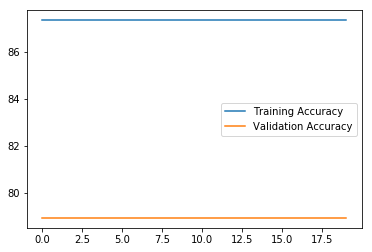

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 84.21052631578948%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 84.21052631578948. Model named cnn_1518543331.


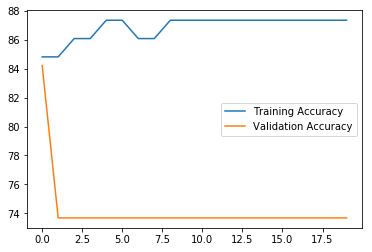

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 84.21052631578948%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 84.21052631578948. Model named cnn_1518543491.


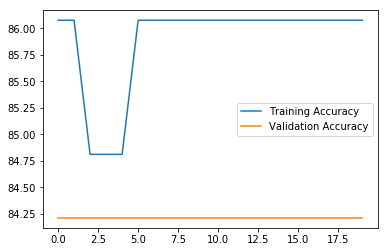

Number of training points:  (77,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 66.66666666666666%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 66.66666666666666. Model named cnn_1518543646.


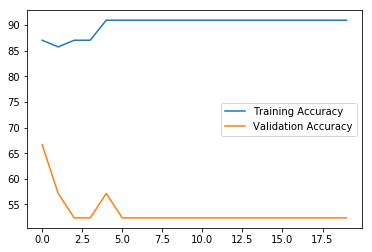

Number of training points:  (78,)
Number of testing points:  (20,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 95.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 95.0. Model named cnn_1518543801.


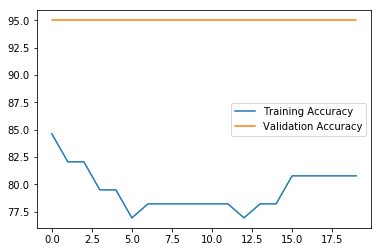

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 84.21052631578948%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 84.21052631578948. Model named cnn_1518543963.


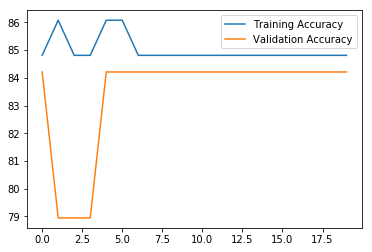

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 84.21052631578948%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 84.21052631578948. Model named cnn_1518544123.


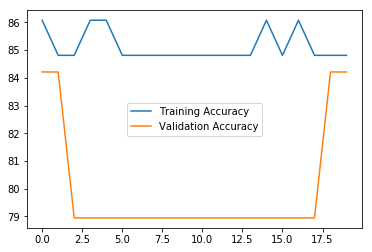

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 89.47368421052632%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 89.47368421052632. Model named cnn_1518544283.


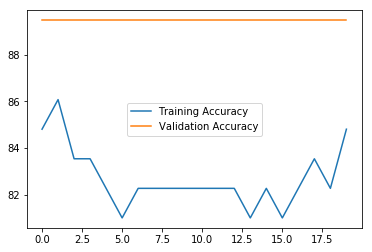

Number of training points:  (77,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 80.95238095238095%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 80.95238095238095. Model named cnn_1518544437.


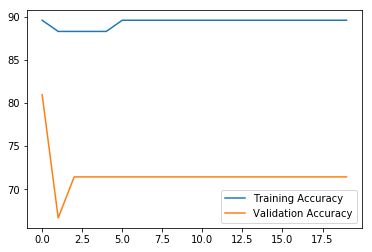

Number of training points:  (78,)
Number of testing points:  (20,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 85.0%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 90.0%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 90.0. Model named cnn_1518544599.


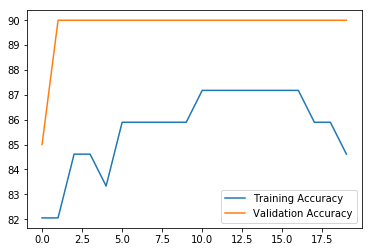

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 84.21052631578948%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 84.21052631578948. Model named cnn_1518544765.


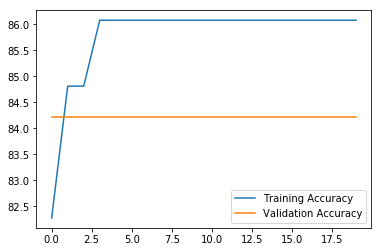

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 89.47368421052632%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
Best validation accuracy! iteration:99 accuracy: 94.73684210526315%
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 94.73684210526315. Model named cnn_1518544919.


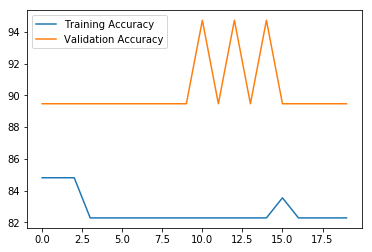

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 94.73684210526315%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 94.73684210526315. Model named cnn_1518545077.


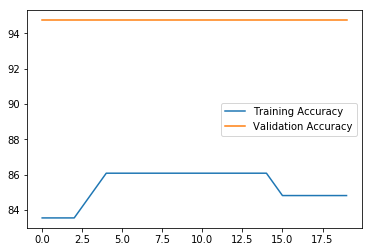

Number of training points:  (77,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 85.71428571428571%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Best validation accuracy! iteration:180 accuracy: 90.47619047619048%
Traning ends. The best valid accuracy is 90.47619047619048. Model named cnn_1518545238.


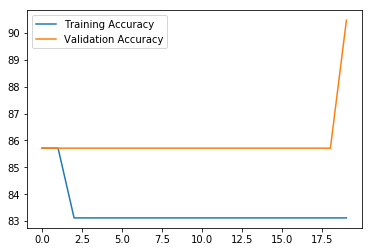

Number of training points:  (78,)
Number of testing points:  (20,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 80.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 80.0. Model named cnn_1518545405.


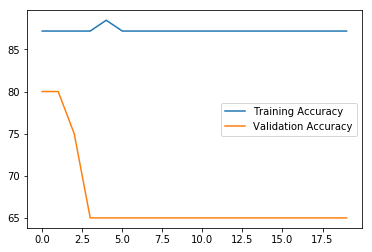

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 84.21052631578948%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 84.21052631578948. Model named cnn_1518545556.


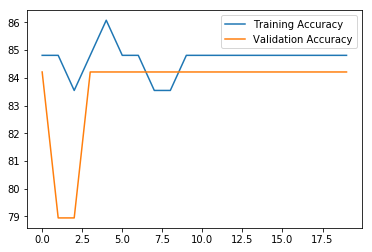

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 84.21052631578948%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 84.21052631578948. Model named cnn_1518545702.


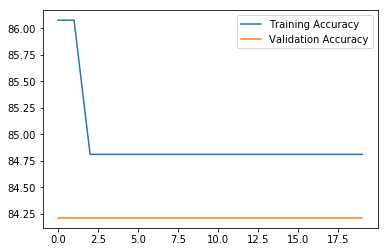

Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 89.47368421052632%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 89.47368421052632. Model named cnn_1518545853.


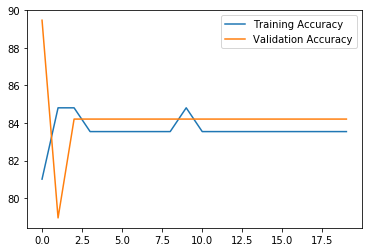

MCI_SMI average accuracy is:  86.59147869674185


In [98]:
from sklearn.model_selection import RepeatedStratifiedKFold
from CNN_codes.CNN_test import cnn_training

rskf=RepeatedStratifiedKFold(n_splits=5,n_repeats=5)
store_acc=[]
for train_index,test_index in rskf.split(X_mcismi,y_mcismi):
    print("Number of training points: ",train_index.shape)
    print('Number of testing points: ',test_index.shape)
    X_train,X_test=X_mcismi[train_index],X_mcismi[test_index]
    y_train,y_test=y_mcismi[train_index],y_mcismi[test_index]
    tf.reset_default_graph()
    record_acc,recordtrainacc,recordvalacc=cnn_training(X_train,y_train,X_test,y_test,fc_units=[500,200,2], 
                 conv_featmap=[6,10,20],l2_norm=0.01,seed=235,
                 learning_rate=1e-3,epoch=20,batch_size=8,imglen=164)
    store_acc.append(record_acc)
    plt.plot(recordtrainacc,label='Training Accuracy')
    plt.plot(recordvalacc,label="Validation Accuracy")
    plt.legend()
    plt.show()

mean_acc=np.mean(np.array(store_acc))
print('MCI_SMI average accuracy is: ',mean_acc)


Number of training points:  (137,)
Number of testing points:  (35,)
Building Network Parameters: 
fc_units=[100, 50, 2]
l2_norm=0.1
seed=235
learning_rate=0.001
number of batches for training: 17
epoch 1 
Best validation accuracy! iteration:17 accuracy: 68.57142857142857%
epoch 2 
Best validation accuracy! iteration:34 accuracy: 74.28571428571428%
epoch 3 
Best validation accuracy! iteration:51 accuracy: 77.14285714285714%
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
Best validation accuracy! iteration:357 accuracy: 82.85714285714286%
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
Best validation accuracy! iteration:850 

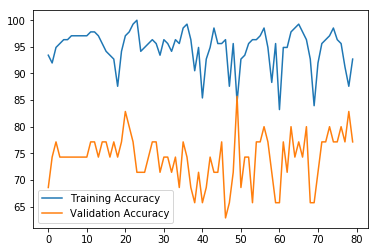

Number of training points:  (137,)
Number of testing points:  (35,)
Building Network Parameters: 
fc_units=[100, 50, 2]
l2_norm=0.1
seed=235
learning_rate=0.001
number of batches for training: 17
epoch 1 
Best validation accuracy! iteration:17 accuracy: 65.71428571428572%
epoch 2 
Best validation accuracy! iteration:34 accuracy: 74.28571428571428%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
Best validation accuracy! iteration:255 accuracy: 80.0%
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
e

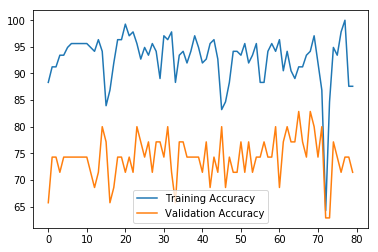

Number of training points:  (138,)
Number of testing points:  (34,)
Building Network Parameters: 
fc_units=[100, 50, 2]
l2_norm=0.1
seed=235
learning_rate=0.001
number of batches for training: 17
epoch 1 
Best validation accuracy! iteration:17 accuracy: 70.58823529411765%
epoch 2 
Best validation accuracy! iteration:34 accuracy: 73.52941176470588%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
Best validation accuracy! iteration:374 accuracy: 79.41176470588235%
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
Best validation accuracy! iteration:782 accuracy: 82.35294117647058%
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 

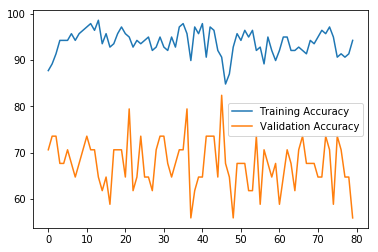

Number of training points:  (138,)
Number of testing points:  (34,)
Building Network Parameters: 
fc_units=[100, 50, 2]
l2_norm=0.1
seed=235
learning_rate=0.001
number of batches for training: 17
epoch 1 
Best validation accuracy! iteration:17 accuracy: 79.41176470588235%
epoch 2 
Best validation accuracy! iteration:34 accuracy: 85.29411764705883%
epoch 3 
Best validation accuracy! iteration:51 accuracy: 88.23529411764706%
epoch 4 
epoch 5 
epoch 6 
epoch 7 
Best validation accuracy! iteration:119 accuracy: 91.17647058823529%
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 


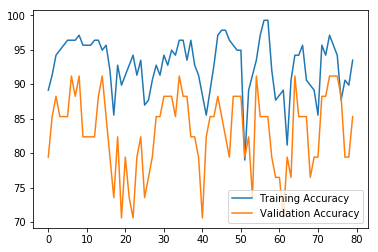

Number of training points:  (138,)
Number of testing points:  (34,)
Building Network Parameters: 
fc_units=[100, 50, 2]
l2_norm=0.1
seed=235
learning_rate=0.001
number of batches for training: 17
epoch 1 
Best validation accuracy! iteration:17 accuracy: 76.47058823529412%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
Best validation accuracy! iteration:255 accuracy: 79.41176470588235%
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
Best validation accuracy! iteration:527 accuracy: 82.35294117647058%
epoch 32 
Best validation accuracy! iteration:544 accuracy: 85.29411764705883%
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54

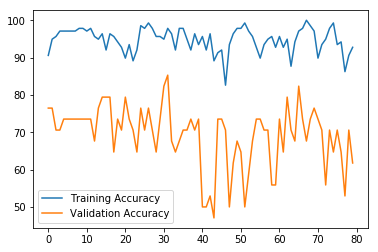

AD_MCI average accuracy is:  85.47899159663865
[85.71428571428571, 82.85714285714286, 82.35294117647058, 91.17647058823529, 85.29411764705883]


In [14]:
from sklearn.model_selection import RepeatedStratifiedKFold
from CNN_codes.CNN_test import cnn_training

rskf=RepeatedStratifiedKFold(n_splits=5,n_repeats=1)
store_acc=[]
for train_index,test_index in rskf.split(X_admci,y_admci):
    print("Number of training points: ",train_index.shape)
    print('Number of testing points: ',test_index.shape)
    X_train,X_test=X_admci[train_index],X_admci[test_index]
    y_train,y_test=y_admci[train_index],y_admci[test_index]
    tf.reset_default_graph()
    record_acc,recordtrainacc,recordvalacc=cnn_training(X_train,y_train,X_test,y_test,fc_units=[100,50,2], 
                 conv_featmap=[6,8,12],l2_norm=0.1,seed=235,
                 learning_rate=1e-3,epoch=80,batch_size=8,imglen=164)
    store_acc.append(record_acc)
    plt.plot(recordtrainacc,label='Training Accuracy')
    plt.plot(recordvalacc,label="Validation Accuracy")
    plt.legend()
    plt.show()

mean_acc=np.mean(np.array(store_acc))
print('AD_MCI average accuracy is: ',mean_acc)
print(store_acc)

TRAIN: [ 0  1  2  3  4  5  6  7  9 10 13 14 15 16 17 18 19 20 23 24 25 28 29 30
 32 33 34 35 36 37 38 39 41 42 43 44 45 46 47 48 50 52 53 54 57 58 59 60
 61 62 63 65 66 69 70 72 73 75 76 78 79 80 81 82 84 85 86 87 88 89 90 91
 92 93 94 96 97] TEST: [ 8 11 12 21 22 26 27 31 40 49 51 55 56 64 67 68 71 74 77 83 95]
Number of training points:  (77,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 15
epoch 1 
Best validation accuracy! iteration:15 accuracy: 95.23809523809524%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 95.23809523809524. Model named cnn_1518560288.


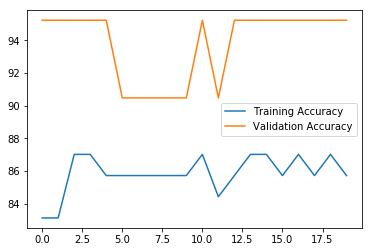

TRAIN: [ 0  2  3  5  6  7  8  9 10 11 12 13 14 16 17 20 21 22 23 24 25 26 27 28
 29 31 33 34 35 36 37 39 40 41 42 43 44 45 46 48 49 51 54 55 56 57 58 60
 62 63 64 65 66 67 68 70 71 72 74 75 76 77 78 79 80 82 83 84 86 87 88 89
 90 92 93 95 96 97] TEST: [ 1  4 15 18 19 30 32 38 47 50 52 53 59 61 69 73 81 85 91 94]
Number of training points:  (78,)
Number of testing points:  (20,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 15
epoch 1 
Best validation accuracy! iteration:15 accuracy: 80.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:75 accuracy: 85.0%
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 85.0. Model named cnn_1518560489.


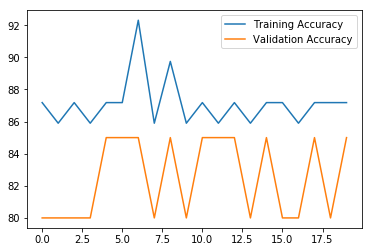

TRAIN: [ 1  4  7  8  9 10 11 12 15 16 17 18 19 20 21 22 23 24 25 26 27 29 30 31
 32 35 36 37 38 39 40 41 42 44 45 46 47 48 49 50 51 52 53 54 55 56 57 59
 60 61 64 65 66 67 68 69 70 71 72 73 74 75 77 78 79 80 81 82 83 85 87 88
 90 91 92 93 94 95 96] TEST: [ 0  2  3  5  6 13 14 28 33 34 43 58 62 63 76 84 86 89 97]
Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 15
epoch 1 
Best validation accuracy! iteration:15 accuracy: 84.21052631578948%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 84.21052631578948. Model named cnn_1518560691.


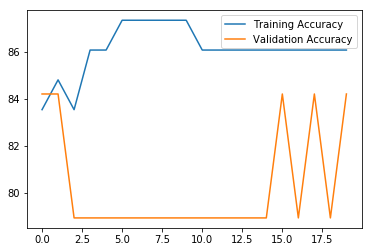

TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 26 27
 28 29 30 31 32 33 34 37 38 40 41 43 44 45 47 49 50 51 52 53 54 55 56 58
 59 61 62 63 64 65 67 68 69 70 71 73 74 76 77 79 80 81 83 84 85 86 88 89
 90 91 92 93 94 95 97] TEST: [ 7 20 24 25 35 36 39 42 46 48 57 60 66 72 75 78 82 87 96]
Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 15
epoch 1 
Best validation accuracy! iteration:15 accuracy: 78.94736842105263%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 78.94736842105263. Model named cnn_1518560891.


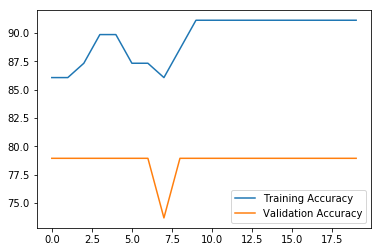

TRAIN: [ 0  1  2  3  4  5  6  7  8 11 12 13 14 15 18 19 20 21 22 24 25 26 27 28
 30 31 32 33 34 35 36 38 39 40 42 43 46 47 48 49 50 51 52 53 55 56 57 58
 59 60 61 62 63 64 66 67 68 69 71 72 73 74 75 76 77 78 81 82 83 84 85 86
 87 89 91 94 95 96 97] TEST: [ 9 10 16 17 23 29 37 41 44 45 54 65 70 79 80 88 90 92 93]
Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 15
epoch 1 
Best validation accuracy! iteration:15 accuracy: 84.21052631578948%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 84.21052631578948. Model named cnn_1518561091.


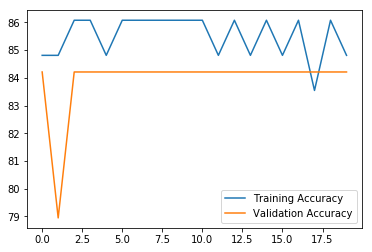

TRAIN: [ 1  3  4  5  6  8  9 10 11 13 14 18 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 37 38 39 40 41 42 43 45 46 47 48 49 51 52 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 70 71 73 74 76 79 80 81 82 83 84 87 88 89 90 91
 92 93 94 95 97] TEST: [ 0  2  7 12 15 16 17 19 36 44 50 53 54 69 72 75 77 78 85 86 96]
Number of training points:  (77,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 15
epoch 1 
Best validation accuracy! iteration:15 accuracy: 85.71428571428571%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 85.71428571428571. Model named cnn_1518561331.


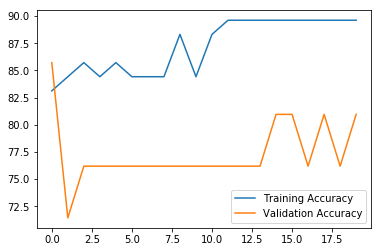

TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 19 20 21 22 23 24 25 26
 28 29 30 31 32 33 35 36 37 39 40 43 44 45 46 47 50 51 52 53 54 55 57 59
 60 62 63 64 65 67 69 70 72 73 75 76 77 78 79 80 81 82 84 85 86 87 88 90
 91 92 93 94 96 97] TEST: [ 1 14 18 27 34 38 41 42 48 49 56 58 61 66 68 71 74 83 89 95]
Number of training points:  (78,)
Number of testing points:  (20,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 15
epoch 1 
Best validation accuracy! iteration:15 accuracy: 90.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 90.0. Model named cnn_1518561569.


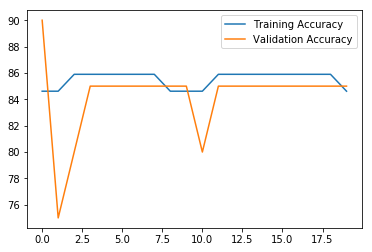

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 23 27 28 29
 30 31 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 56 57 58
 60 61 62 64 65 66 67 68 69 70 71 72 74 75 77 78 79 81 83 85 86 87 88 89
 90 91 92 93 95 96 97] TEST: [10 21 22 24 25 26 32 35 37 51 55 59 63 73 76 80 82 84 94]
Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 15
epoch 1 
Best validation accuracy! iteration:15 accuracy: 73.6842105263158%
epoch 2 
Best validation accuracy! iteration:30 accuracy: 84.21052631578948%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 84.21052631578948. Model named cnn_1518561800.


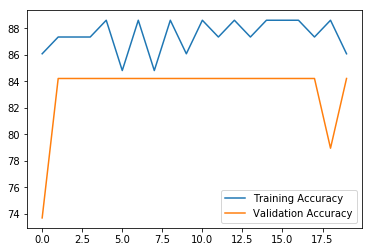

TRAIN: [ 0  1  2  5  7 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 31 32 34 35 36 37 38 41 42 44 47 48 49 50 51 52 53 54 55 56 58 59 61 62
 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 80 81 82 83 84 85 86 88
 89 90 93 94 95 96 97] TEST: [ 3  4  6  8  9 13 30 33 39 40 43 45 46 57 60 79 87 91 92]
Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 15
epoch 1 
Best validation accuracy! iteration:15 accuracy: 78.94736842105263%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 78.94736842105263. Model named cnn_1518562032.


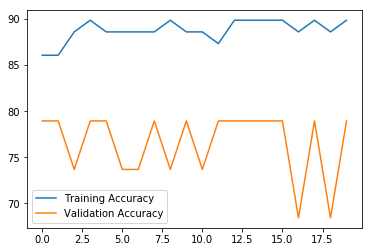

TRAIN: [ 0  1  2  3  4  6  7  8  9 10 12 13 14 15 16 17 18 19 21 22 24 25 26 27
 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 48 49 50 51 53 54 55 56
 57 58 59 60 61 63 66 68 69 71 72 73 74 75 76 77 78 79 80 82 83 84 85 86
 87 89 91 92 94 95 96] TEST: [ 5 11 20 23 28 29 31 47 52 62 64 65 67 70 81 88 90 93 97]
Number of training points:  (79,)
Number of testing points:  (19,)
Building Network Parameters: 
fc_units=[500, 200, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 15
epoch 1 
Best validation accuracy! iteration:15 accuracy: 94.73684210526315%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 94.73684210526315. Model named cnn_1518562262.


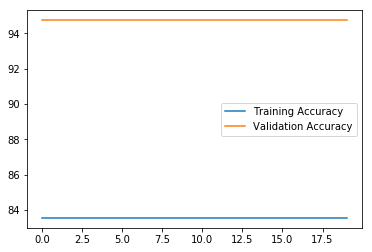

MCI_SMI average accuracy is:  86.12155388471177
[95.23809523809524, 85.0, 84.21052631578948, 78.94736842105263, 84.21052631578948, 85.71428571428571, 90.0, 84.21052631578948, 78.94736842105263, 94.73684210526315]


In [15]:
from sklearn.model_selection import RepeatedStratifiedKFold
from CNN_codes.CNN_test import cnn_training

rskf=RepeatedStratifiedKFold(n_splits=5,n_repeats=2)
store_acc=[]
for train_index,test_index in rskf.split(X_mcismi,y_mcismi):
    print("TRAIN:",train_index,"TEST:",test_index)
    print("Number of training points: ",train_index.shape)
    print('Number of testing points: ',test_index.shape)
    X_train,X_test=X_mcismi[train_index],X_mcismi[test_index]
    y_train,y_test=y_mcismi[train_index],y_mcismi[test_index]
    tf.reset_default_graph()
    record_acc,recordtrainacc,recordvalacc=cnn_training(X_train,y_train,X_test,y_test,fc_units=[500,200,2], 
                 conv_featmap=[6,10,20],l2_norm=0.01,seed=235,
                 learning_rate=1e-3,epoch=20,batch_size=5,imglen=164)
    store_acc.append(record_acc)
    plt.plot(recordtrainacc,label='Training Accuracy')
    plt.plot(recordvalacc,label="Validation Accuracy")
    plt.legend()
    plt.show()

mean_acc=np.mean(np.array(store_acc))
print('MCI_SMI average accuracy is: ',mean_acc)
print(store_acc)